# Optimising OpenCL applications

Optimal performance for OpenCL applications is a complex multi-dimensional problem. It depends not only on peak utilisation of compute units, but also the timeliness and speed that memory is passed in and out of compute units. It is a general rule that vendor-specific libraries are the best way to achieve optimal compute performance, however for OpenCL these libraries are often not available. At the same time OpenCL implementations and their underlying hardware have smart technologies to optimise processing for commonly used computing operations, and sometimes the simplest approach works best. At other times better compute performance comes at a significant increase in complexity of the program. CPU's and GPU's architectures are optimsed for different ways of computing. This means that a kernel that performs well on a CPU might perform poorly on a GPU, and vice-versa. Experimentation is the key. In the following sections we will try a number of experiments and see what kind of difference they make to the matrix multiplication problem.

## Fundamentals of CPU and GPU architectures

It is helpful to first cover the fundamentals of computer architectures and explore differences between CPU's and GPU's. 

### Hardware threads and processing elements

From the introduction we have seen that that a processor is partioned into cores and each core provides a number of hardware threads that become the processing elements for an OpenCL kernel. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/Intel-8th-Gen Core-3.jpg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A processor die showing an eighth-generation <span>Intel&trade;</span> <span>Core&trade;</span> processor. Image used with permission courtesy of Intel Corporation. </figcaption>
</figure>

Cores have a clock cycle and can perform a limited number of instructions per cycle. During a computation instructions such as math commands are executed on the hardware threads, using memory that is passed in and out of the core from a hierarchy of caches. If this memory does not arrive on time, or get disposed of on time, then the hardware threads will stall and peak theoretical performance will not be acheived.

### Cache topics

#### Hierarchy

The fastest memory in a processor (CPU or GPU) are the registers. They operate at or near the same clock speed as the CPU and are located on the CPU die. This memory is not cheap however, and memory for a computation is shuffled to and from the processor through a hierarchy of caches with the following sizes and locations:

* Register, fastest memory (few kB)
* L1 cache, fast on-die memory (tens of kB)
* L2 cache, fast on-die memory (hundreds of kB)
* L3 cache, fast memory near the device or on-die. (few MB to tens of MB)
* Global or device memory (RAM, few GB onwards)

The most used memory is stored in the lowest level caches. Memory that is not used as often is evicted to the slower caches as necessary. Memory that is rarely at all is flushed out to global memory.

#### Cache lines - the fundamental unit of memory transactions

Memory passed from caches doesn't arrive at the CPU in units of individual bytes, instead it arrives in transactional units called cache lines. Cache lines are around 64-128 bytes, which can store 16-32 floating point numbers.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:60%">
    <img style="vertical-align:middle" src="../images/cache_line.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: A cache line 64 bytes wide. </figcaption>
</figure>

This means that if a processor needs to fetch from or store a value in memory, then the cache hierarchy must transport the **entire cache line** in which the value is located. Caches have slots in them where cache lines can be stored, however if a cache line is not in the faster caches, then it must be fetched from main memory at the cost of wasted processor cycles. 

> A key to achieving good performance with memory is to then **try and use as many neighbouring elements in cache line as possible** by subsequently fetching and storing memory that is in the immediate "neighbourhood" of the initial memory access. 

In the context of OpenCL it is advantageous if a work-item or work-items in a workgroup access neighbouring memory locations. Then memory transfers can be combined in what is known as **coalesced memory access**.

#### Latency

Latency is the number of cycles a processing element has to wait for memory to arrive from a cache. here are some indicative numbers on latency for CPU and GPU caches.

| Cache | memory latency (clock cycles on a CPU) | memory latency (clock cycles on a GPU)
|:----:|-----:|-----:|
|   Register  | ~1 | ~20 |
|   L1  | ~4 | ~30-100|
| L2 | ~12 | ~175-300 |
| L3 | ~24-32 | NA |
| Device memory | >= 100 | 300-800 | 

Sources for these numbers: [GPU numbers 1](http://lpgpu.org/wp/wp-content/uploads/2013/05/poster_andresch_acaces2014.pdf), [GPU numbers 2](https://arxiv.org/pdf/1804.06826.pdf), [CPU numbers](http://techreport.com/review/27018/intel-xeon-e5-2687w-v3-processor-reviewed/4).

#### Throughput

Throughput is a measure of how fast memory can be transported from a cache to the processing element. As follows is a rough guide on what one can expect to see from CPU and GPU cache throughput.

| Cache | speed (GB/s on a CPU) | speed (GB/s on a GPU) |
|:----:|-----:|-----:|
|   L1  | 2000-4000 | ~1000+ |
| L2 | 1000-1500 | ~1000 |
| L3 | 500-1000 |NA|
| Device memory | 16 - 128 | 100-1200 |

Sources for these numbers: [CPU numbers](http://www.tested.com/tech/457440-theoretical-vs-actual-bandwidth-pci-express-and-thunderbolt), [GPU numbers](http://meseec.ce.rit.edu/551-projects/spring2015/3-2.pdf)

#### Thoughts on latency and throughput with OpenCL kernels in mind

With either CPU or GPU processors we must make sure to make best use of cache lines. This means creating workgroups whose neighbouring work items also work on neighbouring elements of a memory allocation. It seems that throughput from global memory is significant faster on a GPU device, however memory will take more cycles to arrive. 

### Floating point operations

Math operations (such as multiply or add) on floating point numbers are an essential component of scientific applications. These operations are typically performed on 32- or 64-bit numbers, however 16-bit operations are becoming popular in machine learning as those do not require extremely precise calculations. Performance of a processor is measured in FLOPS, or the total number of floating point operations its compute units can perform in one second. At the time of writing units of gigaFLOPS ($10^{9}$ FLOPS) or teraFLOPS ($10^{12}$ FLOPS) are commonly used to describe compute device performance.

The raw floating point performance of a compute device is very much dependent on precision and wether or not the architecture is built for it. Gaming hardware is often optimised for 32-bit floats, and 64-bit processing may be emulated in software or accomplished with fewer cores. For example the RTX3060 graphics card has a 64-bit floating point processing rate that is **64 times lower** than 32-bit due to 64 times fewer 64-bit capable processing elements. CPU's have SIMD processing units that can process vectors of floats with a single instruction. At the time of writing vectors of up to 512 bits (16 floats) can be processed by AVX-512 instructions.

Compute performance within a kernel is also determined by the type of math instruction performed. 
> Addition, multiplication, and fused multiply-add are among the **cheapest** operations to perform (costing a few processor cycles), whereas division, square-root, and trigonometric functions are typically an **order of magnitude** more expensive. Writing your kernels to minimise expensive math operations will help, but waiting for memory is time consuming, and during those times kernel math can often be done for free.

### CPU architecture specifics

CPU's usually have fewer than 100 cores, but each core has sophisticated instruction handling and nice things like pre-emptive memory fetching and branch prediction. One can think of CPU cores as smart workers, and the cache latency timings above means they are more nimble than GPU's. CPU's have registers, and on-die L1 and L2 caches. The L3 cache is usually also on-die, but is in an area that is commonly accessible to other cores. In <span>AMD&trade; Zen&trade; 3+</span>  CPU's the cores are grouped in chiplets of 8 cores called core complexes (CCX's), and the L3 cache is located in an area of the chiplet with access from each core. 

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:80%">
    <img style="vertical-align:middle" src="../images/cpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Section of a CPU processor, showing cores with floating point SIMD units and integer pipelines. </figcaption>
</figure>

With OpenCL we might be able to use [clCreateSubDevices](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clCreateSubDevices.html) to partition a CPU into sub-devices, so that workgroups can run on a single chiplet. In terms of math operations, CPU's have integer processing and SIMD (Single Instruction Multiple Data) units that can process vectors of floating point numbers. At the time of writing vectors of up to 8-16 floats (AVX2-AVX512) may be processed at a time using the SIMD units of a CPU. It depends largely on what kind of vector instructions are supported by the chipset.

> Getting good floating point performance from a CPU is **critically** dependent on wether or not one can effectively leverage the SIMD units of the CPU. Using **vectors** in OpenCL kernel is a way to provide strong hints the to implementation's device compiler to emit vector instructions that work on the CPU.

#### Example specifications

Here are some of the top CPU's at the moment and their specs.

| CPU | Base clock frequency (GHz) | Cores | Hardware threads | L1 Cache (KB) | L2 Cache (KB) | L3 cache (MB) | FP SIMD width (bits) | Tflops (FP32 calculated) |
|:----:|-----:| -----: | -----: | :----: | :----: | :----: | :----: | :----: |
| Intel Xeon Platinum 8380HL | 2.9 | 28 | 56 | 28x64 | 28x1024 | 38.5 | 512 | 1.3 |
| AMD EPYC 7H12 | 2.6 | 64 | 128 | 64x32 | 64x512 | 16x16 | 256 | 1.3 |

Source for the CPU specs [Xeon](http://www.cpu-world.com/CPUs/Xeon/Intel-Xeon%20E7-4850%20v4.html) and [Epyc](https://en.wikipedia.org/wiki/Epyc).

### GPU architecture specifics

There is some confusing terminology surrounding the definition of a processor core in GPU's. GPU's also have processor cores, called **Streaming Multiprocessors** in NVIDIA terminology, **Compute Units** in AMD terminology, and **Xe-Cores** in Intel terminology. Each of these cores schedule instructions and move data in the caches. Instructions are executed in lock-step, over teams of hardware threads. Data for each hardware thread lives in the registers and is manipulated by individual SIMD-like processing elements with floating point capabilities. The terminology for thread teams is called SIMT (Single Instruction Multiple Thread), and individual elements are called **CUDA Cores** in NVIDIA terminology, and **Shader cores** in AMD terminology. The teams are known as **Warps** in NVIDIA terminology and **Wavefronts** in AMD. Teams are 32-64 work items large on NVIDIA hardware, and 64 work items large on AMD hardware.  It appears that Intel have adopted a hybrid approach in using both SIMT and SIMD in their vector units, so using vector instructions might be critical in unlocking performance with OpenCL.

<figure style="margin-bottom 3em; margin-top: 2em; margin-left:auto; margin-right:auto; width:100%">
    <img style="vertical-align:middle" src="../images/gpu_cores.svg"> <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Figure: Floating point units (FP32), registers, and caches for different GPU's. </figcaption>
</figure>

In a GPU there are several cores, and this means that there are thousands of processing elements available to run a kernel on.

> There are a few things to note with the SIMT approaches of NVIDIA and AMD. First of which is that instructions are executed in lock-step. This means that the **ideal workgroup size is going to be a multiple of the work-items in a warp or wavefront**. You can get the the preferred workgroup size using **clinfo** or querying for the **CL_KERNEL_PREFERRED_WORK_GROUP_SIZE_MULTIPLE** attribute for a compiled kernel with [clGetKernelWorkGroupInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetKernelWorkGroupInfo.html). Secondly, branching (using if statements in kernels with multiple execution paths) can be costly, as the whole team must execute all branches sequentially regardless of wether or not work is done. Next, we note there are **many** times more hardware threads available with GPU's, so you need to schedule enough work-items to keep those threads busy. This is known as **occupancy**. Finally, it is important to note that it is the processor core (Streaming Multiprocessor, Compute Unit, or Xe core) that schedules instructions, the individual processing elements are by design not as sophisicated as their CPU counterparts. 

#### Matrix and tensor cores not available in OpenCL

Up to this point I have completely skipped over the extra matrix (AMD, INTEL) and tensor (NVIDIA) core functionality present in modern GPU's. This special matrix processing machinery has applications in machine learning. Unfortunately this ability is not present in OpenCL, and at the time of writing can only be unlocked through vendor implementations such as CUDA, HIP, and OneAPI.

#### Example GPU specifications

Here are some specifications on more recent GPU's. AMD has a more SIMD-like approach to computing floats. Therefore they don't have their own dedicated 64-bit processing elements. Instead 64 bit processing is either emulated or running at half that of 32-bit floats.

| Card | Boost clock (GHz)| Compute Units | FP32 Processing Elements | FP64 Processing Elements (equivalent compute capacity) | L1 Cache (KB) | L2 Cache (KB) | device memory (GB) | Peak Tflops (FP32)| Peak Tflops (FP64)|
|:----:|:-----| :----- | :----- | :---- | :---- | :---- | :---- | :---- | :---- |
| NVIDIA Tesla K40 | 0.875 | 15 | 2880 | 960 | 48 | 1536 | 12 |5.04|1.68|
| NVIDIA Tesla M60 |1.178 |32| 4096| NA | 32x2x48 | 3072 | 8 |4.8|0.151|
| NVIDIA Tesla P100 |1.480| 56 | 3584 | 1792 | 56x64| 4096 | 16 |10.6|5.3|
| NVIDIA Tesla V100 |1.530| 80 | 5120 | 2560 | 80x96 | 6144 | 16 |15.7|7.8|
| NVIDIA Tesla A100 |1.410| 108 | 6912 | 3456 | 108x164 | 40960 | 40 |19.5|9.7|
| AMD Radeon Instinct MI6 |1.233| 36 | 2304 |  | 36x16 | 2000 | 16 |5.73|0.358|
| AMD Radeon Instinct MI8 |1.000| 64 | 4096 |  | 64x16 | 2000 | 4 |8.2|0.512|
| AMD Radeon Instinct MI25 |1.501 | 64 | 4096 |  | 64x16 | 4000 | 16 |12.3 |0.768|
| AMD Radeon Instinct MI50 |1.746 | 60 | 3840 |  | 60x16 | 4000 | 16 |13.4 |6.7|
| AMD Radeon Instinct MI100 |1.502 | 120 | 7680 |  | 120x16 | 8000 | 32|23.1 |11.5|
| AMD Radeon Instinct MI200 |1.7 | 208 | 13312 |  | 208x16 | 16000 | 128 | 90.5 | 45.3 |
| AMD Radeon Instinct MI250x |1.7 | 220 | 14080 |  | 220x16 | 16000 | 128 | 95.7 | 47.9 |

Source for these numbers [Acceleware](https://training.acceleware.com/blog/Tesla-Meets-Maxwell), [NVIDIA](https://devblogs.nvidia.com/inside-volta/), [AMD](https://www.amd.com/en/graphics/servers-radeon-instinct-mi), [Microway](https://www.microway.com/knowledge-center-articles/in-depth-comparison-of-nvidia-tesla-maxwell-gpu-accelerators/), and [TechPowerup](https://www.techpowerup.com/gpudb/2760/tesla-m60).

## Optimising the use of your compute devices

With these principles in mind we can go about exploring ways to improve performance on the matrix multiplication problem.

### Arithmetic intensity and working out where to spend the effort

The **Arithmetic intensity** is the ratio of FLOPS computed per Byte transferred to the processing element. It helps us determine if our algorithm is likely to be constrained by bandwidth or floating point performance. For our problem matrix A is of size ($N0_{C}, N1_{A}$) and B is of size ($N1_{A}, N1_{C}$), every element computed in matrix C requires $N1_A$ loads from A, $N1_A$ loads from B, and 1 store to C. It also requires $N1_A$ multiplications and $N1_A$ additions. The arithmetic intensity of matrix multiplication is then

$$ FB = \frac{2N1_A}{(2N1_A+1)b} $$

where **b** is the number of bytes stored per element. When $N1_A$ is large the **FB** ratio for matrix multiplication is then

$$ FB \approx \frac{1}{b} $$

If a processor has a peak performance of $P_{\mbox{max}}$ FLOPS and a peak bandwidth of $\beta_{\mbox{max}}$ bytes per second, then the problem will be constrained by the device's memory bandwidth if $FB < \frac{P_{\mbox{max}}}{\beta_{\mbox{max}}}$. For example, the AMD Mi250x GPU has a peak 32-bit floating point rate of 95.7 TFLOPS and a peak memory bandwidth of 3.2 TB/s. Problems will be constrained by memory bandwidth up to an arithmetic intensity of 

$$FB_{max}=\frac{95.7}{3.2} \approx 30$$

for more information see the [Wikipedia Article on Roofline Models](https://en.wikipedia.org/wiki/Roofline_model).

Usually the critical **$FB_{\mbox{max}}$** ratio for processors is much larger than $\frac{1}{b} $. What this means for the matrix multiplication problem is the following:

* Usually are not going to get anywhere the rated peak performance of the compute device.
* Optimising memory transfers is where we should concentrate our efforts.
* We can likely get most of compute operations done during memory transfers.
* Speedups over a CPU implementation are more likely to be limited to the difference in memory bandwidth speeds.

### Data precision

In scientific computing the precision and range of 64-bit arithmetic is important, for example in the solution of sensitive differential equations. Compute hardware is often optimised for 32-bit floats though, and if your algorithm supports it you can gain an optimisation by running at lower precision. In the example below we run a matrix multiplication problem at 64-bit and 32-bit precision to see how much of a difference it makes to kernel execution.

In [1]:
import os
import sys
import numpy as np
sys.path.insert(0, os.path.abspath("../include"))

import py_helper

%matplotlib widget

NCOLS_A = 1025
NROWS_C = 1025
NCOLS_C = 1025

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

mat_mul_double=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float64)
mat_mul_float=py_helper.MatMul(NCOLS_A, NROWS_C, NCOLS_C, np.float32)

# Make up objects for timing results and local optimisation
timings=py_helper.TimingResults()
local_opt=py_helper.LocalOpt()

#### Matrix multiplication with 64-bit precision on both CPU and GPU implementations.

In [5]:
!make;
mat_mul_double.make_data()
timings.add_result(
    local_opt.run_problem(["./mat_mult_double.exe","-cpu"], plot=False),
    "Double precision (CPU)"
)

make: Nothing to be done for 'all'.
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 32.597 ms, at the local size of (2,8,1).


In [6]:
!make;
timings.add_result(
    local_opt.run_problem(["./mat_mult_double.exe","-gpu"], plot=False),
    "Double precision (GPU)"
)

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 10.266 ms, at the local size of (4,128,1).


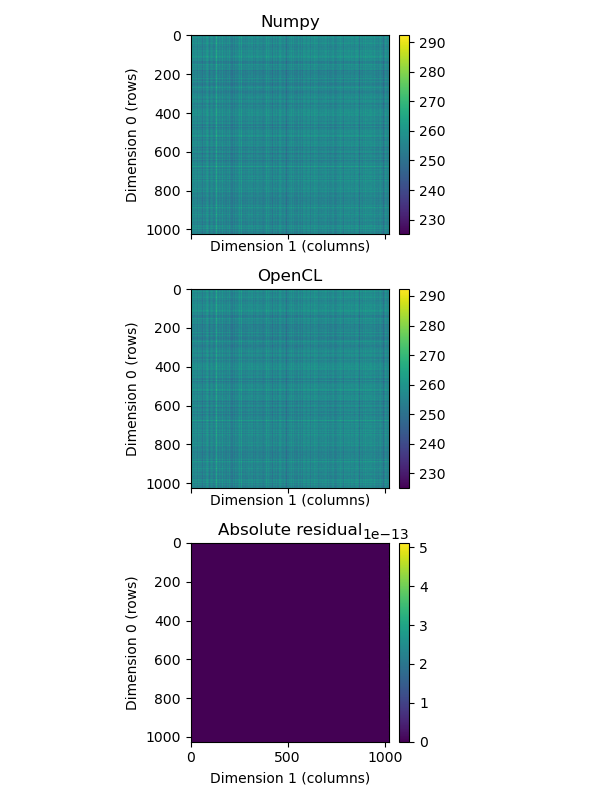

In [7]:
mat_mul_double.check_data()

#### Matrix multiplication again with single precision.

In [8]:
!make;
mat_mul_float.make_data()
timings.add_result(
    local_opt.run_problem(["./mat_mult_float.exe","-cpu"], plot=False),
    "Single precision (CPU)"
)

make: Nothing to be done for 'all'.
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 26.552 ms, at the local size of (8,8,1).


In [9]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_float.exe","-gpu"], plot=False),
    "Single precision (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 2.502 ms, at the local size of (4,16,1).


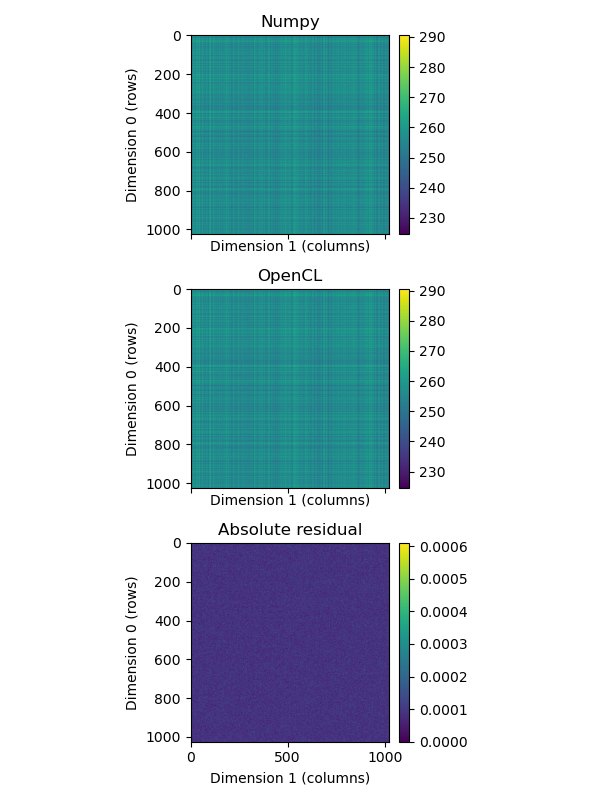

In [10]:
mat_mul_float.check_data()

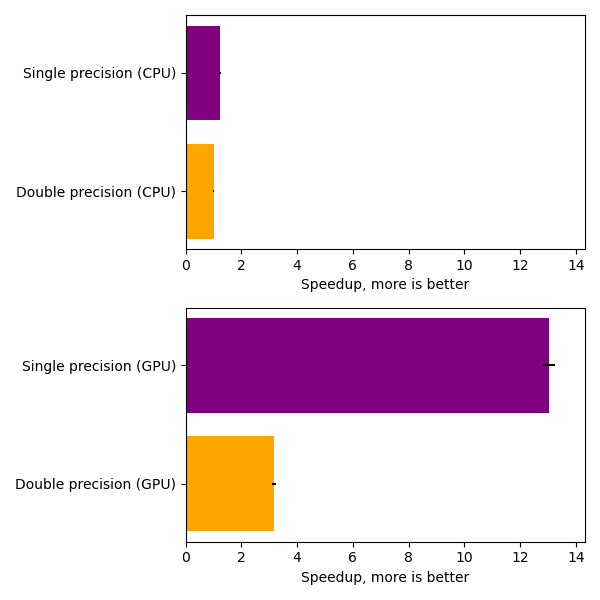

In [11]:
timings.plot_results("Single precision")

#### Conclusions from precision

The single precision results show that using GPU's with 32-bit numbers is clearly a perfomance advantage over 64-bit. While the GPU peak processing rate for 32-bit numbers is many times greater than for 64-bit, the fact that the algorithm is memory bandwidth limited constrains the performance advantage of 32-bit processing to around **6x** over the single precision CPU implementation (appoximately the difference in memory bandwidth), and around **4x** over the double precision GPU implementation.

It appears that on the CPU the difference between single precision and double precision is not significant. This is probably because the processor is designed for 64 bit computing and SIMD vector instructions have not been enabled. Since caches have lower latency on a CPU, the difference in data size being transferred is not significant to effect a performance difference. For GPU's, the 32-bit processing rate is faster, and the data transfer is also halved. This contributes to a 2-4x speedup over the double precision GPU implementation and a 6x speedup over the CPU implementation. 

Unless your algorithm requires high precision then using the lowest precision possible can yields a performance improvement with GPU's due to lower amounts of memory transfer and higher processing rates.


### Occupancy

An active workgroup is one whose work items have started executing. GPU cores best when there are several active workgroups on a core at the same time. This is so latencies (such as fetching from global memory) can be hidden behind execution. Cores have a limit to the number of active workgroups and best performance is achieved when this limit is attained, so-called 100% occupancy.

Some things affect occupancy: 

* If kernels use **too much private memory** then available registers will be depleted, and this limits the number of active workgroups that can be scheduled.
* If kernels use **too much local memory** then it can either reduce occupancy or else local memory spills to global memory at the cost of greater latency.
* If the workload in kernels is **uneven**, (some kernels take a lot longer than others to complete), then occupancy can be curtailed.
* If there simply isn't enough work scheduled.

Some tips for maximising occupancy are then.

* Keep the number of private variables low
* Keep the shared memory size low
* Keep the workload consistent across workgroups
* Use the recommended workgroup size for each kernel. You can get this number by querying for the **CL_KERNEL_PREFERRED_WORK_GROUP_SIZE_MULTIPLE** attribute for a compiled kernel with [clGetKernelWorkGroupInfo](https://www.khronos.org/registry/OpenCL/sdk/3.0/docs/man/html/clGetKernelWorkGroupInfo.html). 
* Every core may have a finite number of workgroups active at any one time. If possible schedule enough workgroups so that every core in the GPU is running with this number of active workgroups.

#### Example

For the matrix multiplication algorithm as it stands, we are using a small number of private variables and we have one work item for every element in matrix C. For a matrix size of $1025^{2}$ there can be just over $1025^2 = 1,050,625$ work items. From the occupancy table in NVIDIA a NVIDIA RTX 3060 with CUDA compute capability 8.6 can have 1,536 threads per streaming multiprocessor active at any one time. Since there are 28 streaming multiprocessors then 28x1536 = 43,008 threads may be active at any one time. Therefore we know there is more than enough work scheduled to keep the streaming multiprocessors busy. In the default matrix multiplication algorithm there is no local memory usage, so we anticipate that the GPU can sustain full occupancy.

### Local size optimisation and coalesced memory access

Performance is a complicated function that is dependent on the performance of the processor and how efficiently cache lines are being used. Local size is a way to control how the compute device accesses memory. In <a href="../include/cl_helper.hpp">cl_helper.hpp</a> is a function called **h_optimise_local** that performs a brute force search over a set of input local size experiments. The function **run_problem** in the Python class **LocalOpt2D** writes a file called **input_local.dat** which contains the experiments. Then during execution **h_optimise_local** reads this file and gathers timing statistics for each experiment. Timing results are written to **output_local.dat** and the **run_problem** reads the results and finds the best performing time. Now we apply this code to find the best performing local size for the basic matrix multiplication algorithm.

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 2.487 ms, at the local size of (4,32,1).


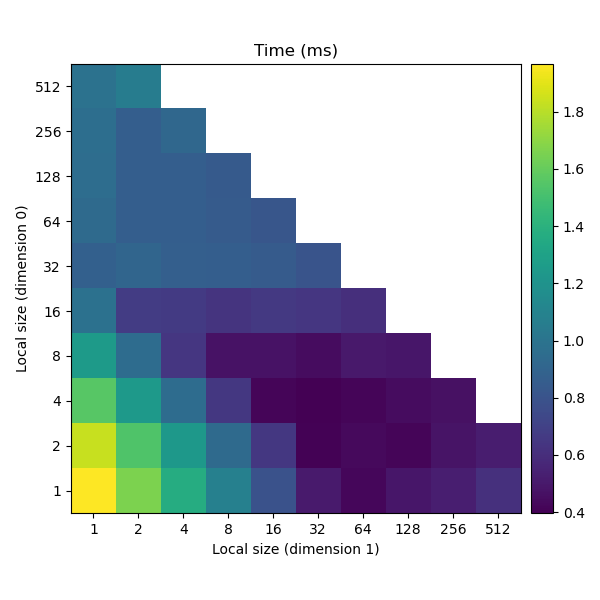

In [12]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_float.exe","-gpu"], plot=True),
    "Single precision (GPU)"
)

From the graph it seems that the best performing local size is one where there is an elongated number of work items along the dimension of contiguous memory access. Efficient cache usage is taking place along the rows of **A** but it may seem counterintuitive for memory access along the columns of **B** until we overlay the cache lines. Then we see that as we loop along the columns of **B**, cache lines are being reused by their neighbouring work items along dimension 1.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/coalesced_memory_access.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Rectangular memory copy.</figcaption>
</figure>

### Prefetching

Within OpenCL kernels there is a command called **prefetch** which can prefetch global memory that is going to be used by a work-item. In the kernel **mat_mult_prefetch** in [kernels_mat_mult.c](kernels_mat_mult.c) we employ a prefetch for row **i0** of matrix A.

```C++
    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C 
    if ((i0<N0_C) && (i1<N1_C)) {
        
        // Implement prefetching for A
        __global float* A_i0 = &A[i0*N1_A];
        __global float* B_i1 = &B[i1];
        prefetch(A_i0, (size_t)N1_A);
    
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            //temp+=A[i0*N1_A+n]*B[n*N1_C+i1];
            temp += A_i0[n]*B_i1[n*N1_C];
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    }
```

Try this out with the kernel timing.

In [13]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_prefetch.exe","-gpu"], plot=False),
    "Prefetch on A (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 2.513 ms, at the local size of (2,32,1).


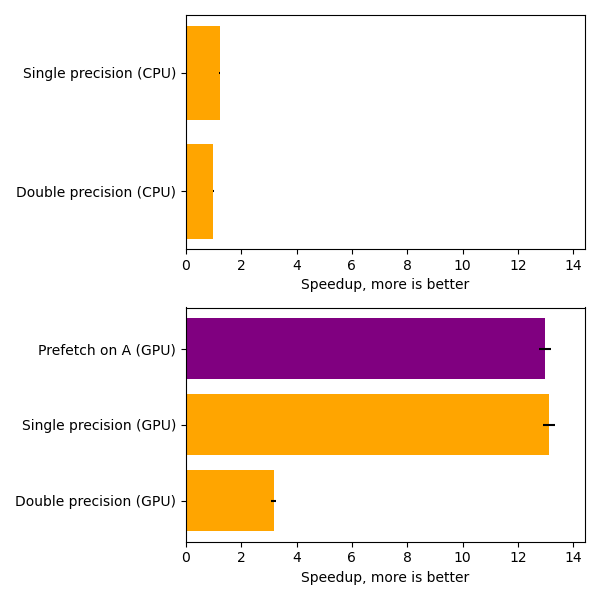

In [14]:
timings.plot_results("Prefetch on A")

From the result above we can see that prefetching makes a slight difference. Nevertheless it still might be useful for applications where you know the memory that will be needed in the cache for a work item.

### Constant memory

We saw in the [Memory Management](../L6_Memory_Management/Memory.ipynb) module memory in the **__constant** address space is stored in a fast cache on the compute device. This storage space is small, on the order of a few tens to a few hundred kilobytes in size. Constant memory is a good storage place for filter coefficients, such as is used for finite difference and convolution operations. 

### Local memory

In the <a href="../L6_Memory_Management/Memory.ipynp">Memory Management Lesson</a> we implemented a naive matrix multiplication implementation that copies all the rows and columns for a workgroup into local memory.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_shmem.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Using local memory in matrix multiplication.</figcaption>
</figure>

If we try to find the optimal local size it ends in disaster.

In [15]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_local.exe","-cpu"], plot=False),
    "Local memory (CPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 73.619 ms, at the local size of (64,64,1).


	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 15.681 ms, at the local size of (4,4,1).


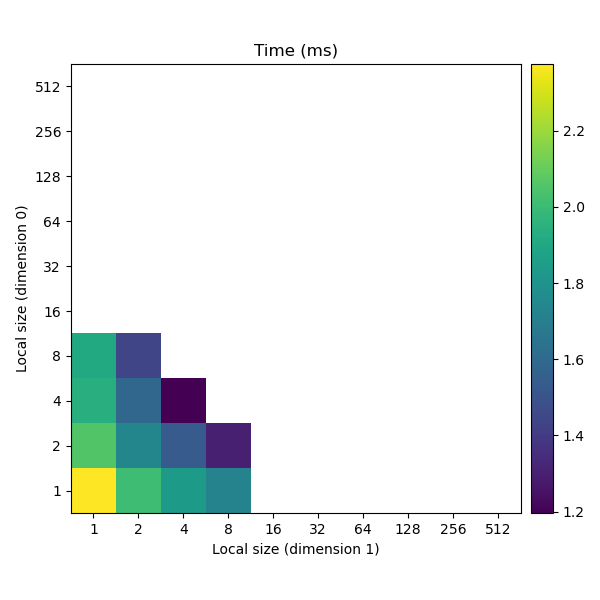

In [16]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_local.exe","-gpu"], plot=True),
    "Local memory (GPU)"
)

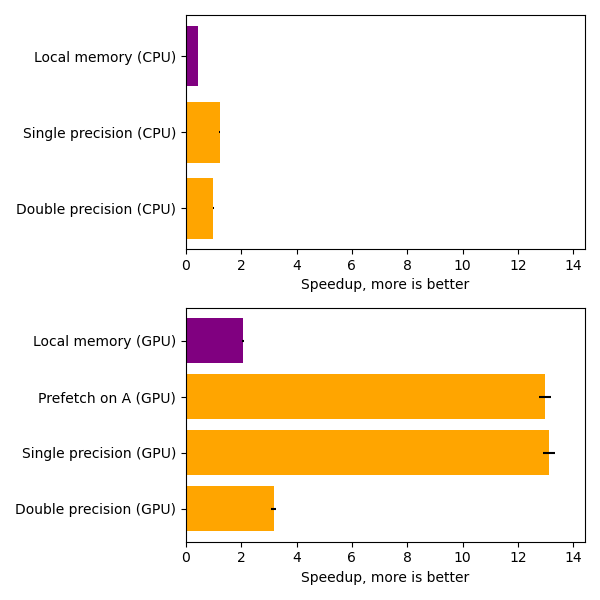

In [17]:
timings.plot_results("Local memory")

These performance results are disappointing. Due to the size of local memory required, only a small subset of the available local sizes are supported, and we aren't getting anywhere near the same performance. When using local memory one has to be careful of allocation size, as too much allocated local memory can limit occupancy or even crash the application.

### Rearrange memory prior to compute

Sometimes there can be a performance benefit if we rearrange memory so that accesses are more optimal. We saw in the local size optimisation section that coalesced memory access is still possible with accesses to matrix B, however is that memory access more or less optimal than that of A?

#### Transposing B

Transposing is swapping the rows and columns of a matrix, row i0 of the matrix becomes column i0 and so forth. We might be able to leverage greater performance by first transposing matrix **B** to make **BT**, so that memory access occurs along the rows of **A** and **BT**.

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_transpose.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Transposed matrix multiplication.</figcaption>
</figure>

In [18]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_transpose_B.exe","-gpu"], plot=False),
    "Transpose B (GPU)"
)

	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 2.971 ms, at the local size of (4,16,1).


In [19]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_transpose_B.exe","-cpu"], plot=False),
    "Transpose B (CPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 44.479 ms, at the local size of (1,8,1).


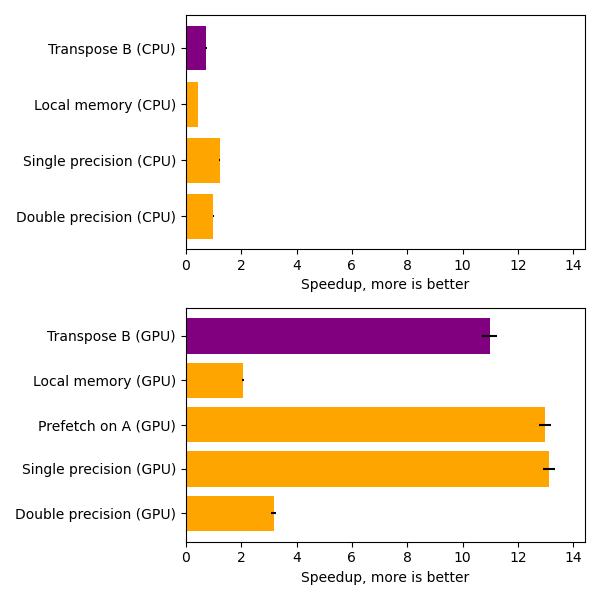

In [20]:
timings.plot_results("Transpose")

By transposing matrix B we see performance that is consistently **worse** than the simple matrix multiplication approach. This is possibly due to multiple workgroups requesting the same cache line. 

#### Transposing A

Let's try transposing A instead.

In [21]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_transpose_A.exe","-cpu"], plot=False),
    "Transpose A (CPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
returncode is 0
Min time is 67.261 ms, at the local size of (64,8,1).


	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
returncode is 0
Min time is 2.690 ms, at the local size of (4,16,1).


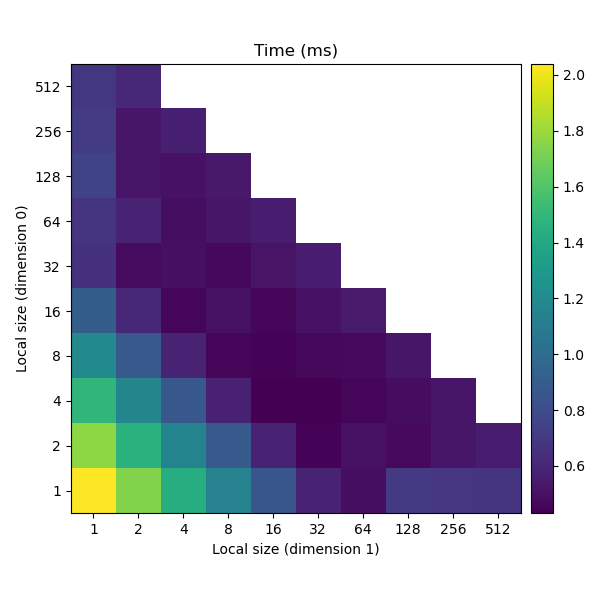

In [22]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_transpose_A.exe","-gpu"], plot=True),
    "Transpose A (GPU)"
)

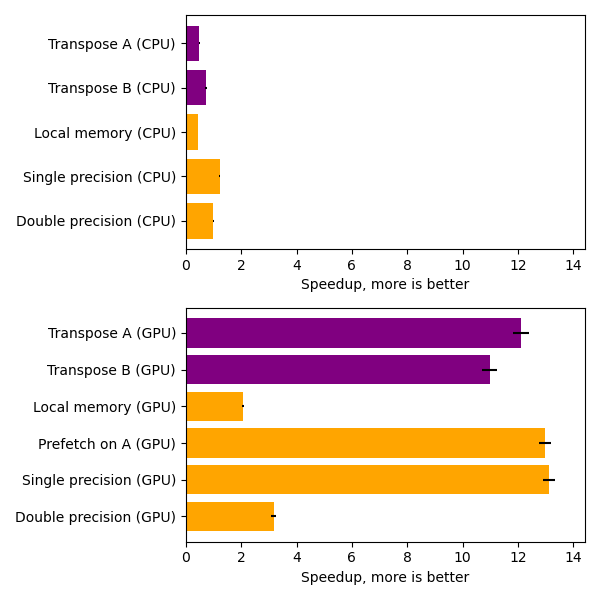

In [23]:
timings.plot_results("Transpose")

If we tranpose **A** instead we get **much better performance on GPU's** but still lesser performance on CPU's. In this instance the tranpose-A algorithm is GPU-specific.

### Tiled memory access

In order to use local memory effectively in workgroups we need to decompose the problem into smaller pieces. We divide up the axis **N1_A**  into chunks of size **chunk_len**. Transposing B beforehand offers a benefit in being able to use vector instructions, and a fixed chunk length is good for performance because we can make **chunk_len** a multiple of elements in a cache line. The number of chunks (N1_A_c) is **N1_A_c = N1_A/chunk_len**, and we pad the **N1_A** axis with zeros so that an integer number of chunks fits into **N1_A**. Each workgroup is a tile (in **C**) that iterates over the number of chunks, and if the local size is **(L0, L1)** then the new allocations of local memory for **A** and **B** is **(L0, chunk_len)** and **(L1, chunk_len)** respectively. Each completed chunk (along row **i0** of **A** and row **i1** of $\textbf{B}^{T}$) represents a partial dot product along the N1_A axis, and work items each use a register to accumulate the sum for placement into **C** at position (i0, i1).

<figure style="margin-left:auto; margin-right:auto; width:100%;">
    <img style="vertical-align:middle" src="../images/matrix_multiplication_tile.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Matrix multiplication with chunked domain decomposition.</figcaption>
</figure>

Here is the source code for the tiled kernel in [kernels_mat_mult.c](kernels_mat_mult.c). Local memory is reused for each chunk. Notice that we also have to place a second barrier call after each chunk is completed to make sure that all work items in a work group are in sync before moving to the next chunk.

```C++
// source code in kernels_mat_mult.c

// Matrix multiply kernel that uses local memory
__kernel void mat_mult_tile_local (
                        __global float* A_star, 
                        __global float* BT_star, 
                        __global float* C,
                        __local float* shared_A_star,
                        __local float* shared_BT_star,
                        unsigned int N1_A_star, 
                        unsigned int N0_C,
                        unsigned int N1_C,
                        unsigned int chunk_len,
                        unsigned int start_chunk_id,
                        unsigned int end_chunk_id) { 
    
    // A_star is of size (N0_C, N1_A_star), (i1, n)
    // BT_star is of size (N1_C, N1_A_star), (i2, n)
    // C is of size (N0_C, N1_C), (i0, i1)
    
    // i1 and i2 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i1=min(get_global_id(0), (size_t)N1_C-1); // Fastest dimension
    size_t i0=min(get_global_id(1), (size_t)N0_C-1); 
    
    // shared_A_star is of size (L0, chunk_len) (s0, n)
    // shared_B_star is of size (L1, chunk_len) (s1, n)
    size_t L0 = get_local_size(1); // Slowest dimension
    size_t L1 = get_local_size(0); // Fastest dimension
    
    // index within local memory
    size_t s0 = get_local_id(1); // Slowest dimension
    size_t s1 = get_local_id(0); // fastest dimension
    
    __local float* shared_A_star_s0 = &shared_A_star[s0*chunk_len];
    __local float* shared_BT_star_s1 = &shared_BT_star[s1*chunk_len];

    // Scratch variable to accumulate the sum
    float temp1=0.0, temp2=0.0;

    // Start and end positions
    size_t start0, end0, start1, end1;
    get_start_end(L1, chunk_len, s1, &start1, &end1);
    get_start_end(L0, chunk_len, s0, &start0, &end0);

    // Loop over the chunks
    for (int chunk_id=start_chunk_id; chunk_id<end_chunk_id; chunk_id++) {

        // Fetch local memory into shared_A_star and shared_B_star
        
        // Starting positions for the copy
        __global float* A_star_i0 = &A_star[i0*N1_A_star+chunk_id*chunk_len];
        __global float* BT_star_i1 = &BT_star[i1*N1_A_star+chunk_id*chunk_len];
          
        // Fill the rows of shared_A_star and shared_B_star
        // From row i1 of A_star
        for (int n = start1; n<end1; n++) {
            shared_A_star_s0[n] = A_star_i0[n];
        }
        
        // From row i2 of B_star
        for (int n = start0; n<end0; n++) {
            shared_BT_star_s1[n] = BT_star_i1[n];
        }
              
        // Enqueue a local barrier to ensure shared memory is filled
        barrier(CLK_LOCAL_MEM_FENCE);
        
        temp1=0.0;

        // Loop over columns of A and rows of B 
        for (size_t n=0; n<chunk_len; n++) {
                
            // Loop across row i0 of A
            // and down column i1 of B
            temp1+=shared_A_star_s0[n]*shared_BT_star_s1[n];
        }

        temp2+=temp1;
        
        // Enqueue a local barrier to ensure all work items 
        // are ready for the next tile
        barrier(CLK_LOCAL_MEM_FENCE);
    }

    // Put the accumulated value into position
    C[i0*N1_C+i1]=temp2;
}

```


make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Cache line size is 128
Time for event "Running transpose kernel": 0.037 ms
returncode is 0
Min time is 8.600 ms, at the local size of (8,32,1).


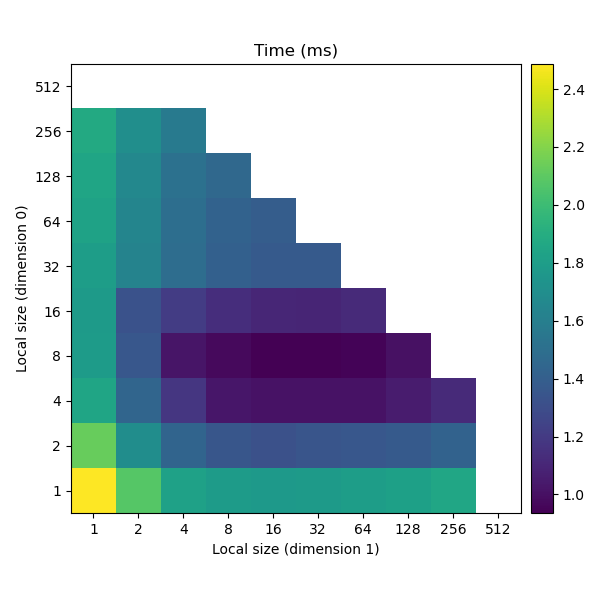

In [24]:
!make
timings.add_result(
    local_opt.run_problem(["./mat_mult_tile_local.exe","-gpu"], plot=True),
    "Tile local (GPU)"
)

	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Cache line size is 64
Time for event "Running transpose kernel": 1.862 ms
returncode is 0
Min time is 66.015 ms, at the local size of (32,32,1).


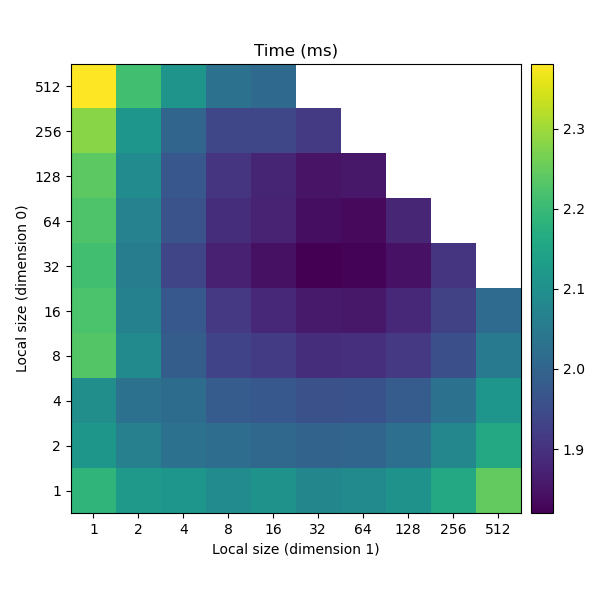

In [26]:
timings.add_result(
    local_opt.run_problem(["./mat_mult_tile_local.exe","-cpu"], plot=True),
    "Tile local (CPU)"
)

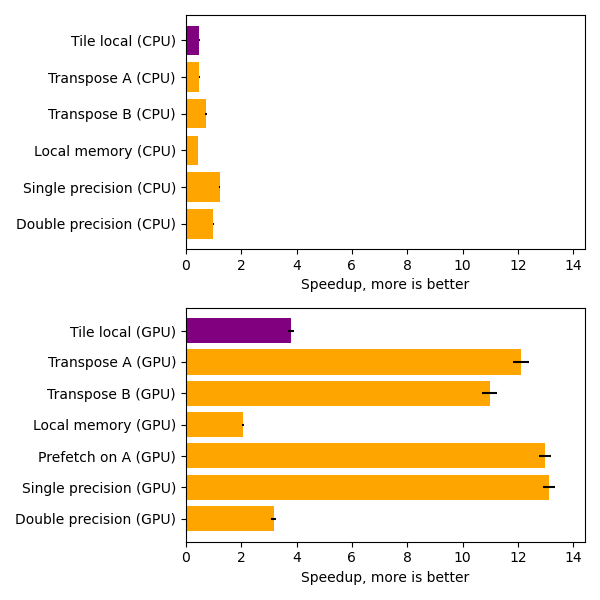

In [27]:
timings.plot_results("Tile local")

On the GPU we recover most (if not all) of the performance of the Transposed A algorithm. This indicates that local memory reuse is effective. On the CPU implementation we still experience sub-optimal performance. It is potentially the result of stalls when CPU threads in a workgroup encounter the barriers.

### Using vectors

Now we see if we can increase performance by using vectors of type **float8**. For implementations such as Intel and AMD, whose compute units benefit from vector instructions, this can provide a boost in performance. For others, such as NVIDIA's the implementation can still benefit from cache performance increases due to vector loads. 

In [28]:
!make
timings.add_result(
    local_opt.run_problem(["./mat_mult_tile_local_vector.exe","-gpu"], plot=False),
    "Tile local vector (GPU)"
)

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 Laptop GPU 
	 global memory size: 6235 MB
	    max buffer size: 1558 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
Cache line size is 128
Time for event "Running transpose kernel": 0.046 ms
returncode is 0
Min time is 6.510 ms, at the local size of (16,32,1).


In [29]:
!make
timings.add_result(
    local_opt.run_problem(["./mat_mult_tile_local_vector.exe","-cpu"], plot=False),
    "Tile local vector (CPU)"
)

make: Nothing to be done for 'all'.
	               name: AMD Ryzen 7 6800H with Radeon Graphics          
	 global memory size: 15994 MB
	    max buffer size: 7997 MB
	     max local size: (8192,8192,8192)
	     max work-items: 8192
Cache line size is 64
Time for event "Running transpose kernel": 0.983 ms
returncode is 0
Min time is 21.123 ms, at the local size of (4,8,1).


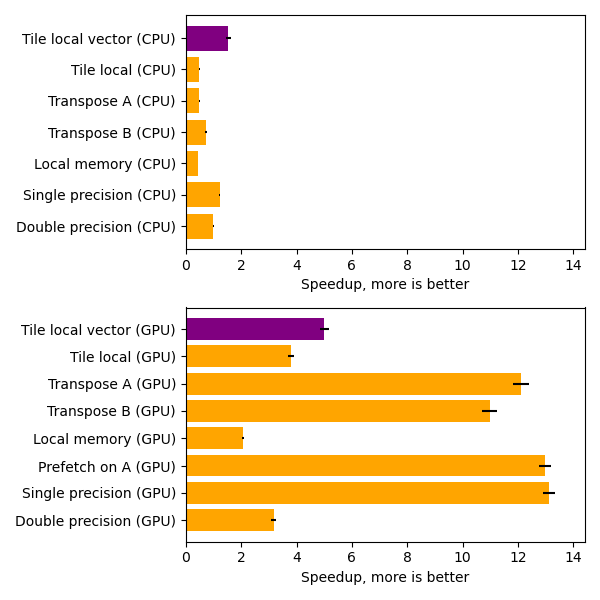

In [30]:
timings.plot_results("Tile local vector")

We can see that using vectors has had a measurable benefit on compute performance, both in the CPU and GPU implementations. There is yet some tuning to be performed on the chunk length. Larger chunk lengths favour CPU implementations.

### Using Multiple devices

#### Domain decomposition

#### Device partitioning

### Using a pre-existing implementation

## Optismising IO to your compute devices

* Shared Virtual Memory
* Pinned memory and DMA transfers
* Overlapping IO with compute


### Research papers

* [Using OpenCL on CPUs](https://www.hindawi.com/journals/sp/2015/859491/)